### This notebook illustrates the use of Cycle GANs for Image2Image Translation on two sets of images (summer and winter).

We take 2 sets of unpaired images (taken randomly and independent of each other) of summer and winter background scenes. Each of these sets is trained to generate images that slook like an image from the other set. There is no relation between any of these images and hence this is unsupervised learning

In [15]:
# Download data 

!wget https://s3.amazonaws.com/video.udacity-data.com/topher/2018/November/5be66e78_summer2winter-yosemite/summer2winter-yosemite.zip
!unzip -q summer2winter-yosemite.zip
!rm summer2winter-yosemite.zip
!mv ./summer2winter_yosemite ./summer2winter-yosemite

--2020-07-14 22:26:16--  https://s3.amazonaws.com/video.udacity-data.com/topher/2018/November/5be66e78_summer2winter-yosemite/summer2winter-yosemite.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.96.254
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.96.254|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 133783376 (128M) [application/zip]
Saving to: ‘summer2winter-yosemite.zip’

summer2winter-yosem 100%[===================>] 127.58M  14.4MB/s    in 11s     

2020-07-14 22:26:28 (12.1 MB/s) - ‘summer2winter-yosemite.zip’ saved [133783376/133783376]



In [45]:
#Importing required libraries

import os 
import torch
from torch.utils.data import DataLoader
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import matplotlib.pyplot as plt
import numpy as np
import warnings

%matplotlib inline

In [13]:

# Define dataloader

def get_data_loader(image_type, image_dir='summer2winter-yosemite',
                    image_size=128, batch_size=16, num_workers=0):
  transform = transforms.Compose([transforms.Resize(image_size),
                                  transforms.ToTensor()])
  
  image_path = './' + image_dir
  train_path = os.path.join(image_path, image_type)
  test_path = os.path.join(image_path, 'test_{}'.format(image_type))

  train_dataset = datasets.ImageFolder(train_path, transform)
  test_dataset = datasets.ImageFolder(test_path, transform)

  train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
  test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

  return train_loader, test_loader

In [50]:
# Create train and test loaders for images X and Y

dataloader_X, test_dataloader_X = get_data_loader(image_type='summer')
dataloader_Y, test_dataloader_Y = get_data_loader(image_type='winter')

In [ ]:
# helper function imshow

def imshow(img):
  npimg = img.numpy()
  plt.imshow(np.transpose(npimg, (1,2,0)))


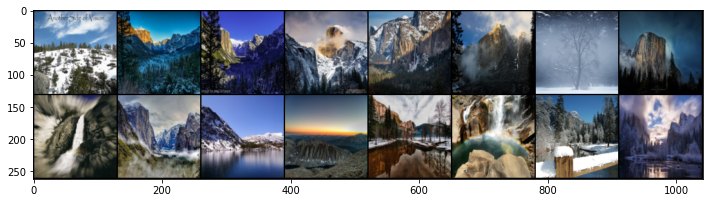

In [51]:
# Winter image samples
dataiter = iter(dataloader_Y)
images, _ = dataiter.next()

fig = plt.figure(figsize=(12,8))
imshow(torchvision.utils.make_grid(images))

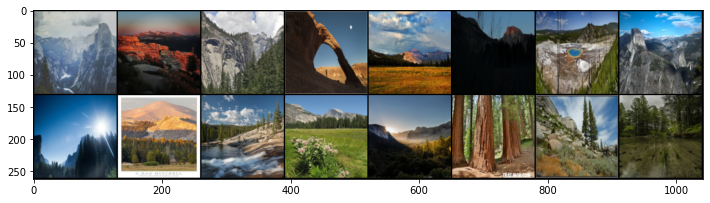

In [52]:
# Summer image samples
dataiter = iter(dataloader_X)
images, _ = dataiter.next()

fig = plt.figure(figsize=(12,8))
imshow(torchvision.utils.make_grid(images))

In [20]:
# Images originally scaled from [0,1] 
print(images[1].min())
print(images[1].max())

tensor(0.)
tensor(0.9176)


In [21]:
def scale(x, feature_range=(-1,1)):
  min, max = feature_range
  x = x*(max-min) + min
  return x

In [22]:
# Images rescaled to [-1,1]
scaled_img = scale(images[1])
print(scaled_img.min())
print(scaled_img.max())

tensor(-1.)
tensor(0.8353)


In [25]:
# helper conv function

def conv(in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm=True):
  layers = []
  conv_layer = nn.Conv2d(in_channels=in_channels, out_channels=out_channels,
                         kernel_size=kernel_size, stride=stride, padding=padding,
                         bias=False)
  layers.append(conv_layer)

  if batch_norm:
    layers.append(nn.BatchNorm2d(out_channels))
  
  return nn.Sequential(*layers)

In [38]:
# Discrimator architecture
class Discriminator(nn.Module):

  def __init__(self, conv_dim=64):
    super(Discriminator, self).__init__()
    self.conv1 = conv(3, conv_dim, 4, batch_norm=False)
    self.conv2 = conv(conv_dim, conv_dim*2, 4)
    self.conv3 = conv(conv_dim*2, conv_dim*4, 4)
    self.conv4 = conv(conv_dim*4, conv_dim*8, 4)

    self.conv5 = conv(conv_dim*8, 1, 4, stride=1, batch_norm=False)

  def forward(self, x):
    out = F.relu(self.conv1(x))
    out = F.relu(self.conv2(out))
    out = F.relu(self.conv3(out))
    out = F.relu(self.conv4(out))

    out = self.conv5(out)
    return out

In [36]:
# Define residual block

class ResidualBlock(nn.Module):
  def __init__(self, conv_dim):
    super(ResidualBlock, self).__init__()

    self.conv1 = conv(in_channels=conv_dim, out_channels=conv_dim,
                      kernel_size=3, stride=1, padding=1, batch_norm=True)
    self.conv2 = conv(in_channels=conv_dim, out_channels=conv_dim,
                      kernel_size=3, stride=1, padding=1, batch_norm=True)
  def forward(self, x):
    out_1 = F.relu(self.conv1(x))
    out_2 = x + self.conv2(out_1)

    return out_2

In [28]:
# helper devonc function

def deconv(in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm=True):
  layers = []
  deconv = nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding, bias=False)
  layers.append(deconv)

  if batch_norm:
    layers.append(nn.BatchNorm2d(out_channels))
  
  return nn.Sequential(*layers)

In [32]:
# Generator architecture

class CycleGenerator(nn.Module):

  def __init__(self, conv_dim=64, n_res_blocks=6):
    super(CycleGenerator, self).__init__()

    # Encoder

    self.conv1 = conv(3, conv_dim, 4)
    self.conv2 = conv(conv_dim, conv_dim*2, 4)
    self.conv3 = conv(conv_dim*2, conv_dim*4, 4)

    # Residual Blocks

    res_layers = []

    for layers in range(n_res_blocks):
      res_layers.append(ResidualBlock(conv_dim*4))

    self.res_blocks = nn.Sequential(*res_layers)

    # Decoder

    self.deconv1 = deconv(conv_dim*4, conv_dim*2, 4)
    self.deconv2 = deconv(conv_dim*2, conv_dim, 4)

    self.deconv3 = deconv(conv_dim, 3, 4, batch_norm=False)

  def forward(self, x):

    out = F.relu(self.conv1(x))
    out = F.relu(self.conv2(out))
    out = F.relu(self.conv3(out))

    out = self.res_blocks(out)

    out = F.relu(self.deconv1(out))
    out = F.relu(self.deconv2(out))
    out = F.tanh(self.deconv3(out))

    return out

In [34]:
# Creating the complete model

def create_model(g_conv_dim=64, d_conv_dim=64, n_res_blocks=6):

  # Instantiate Generators
  G_XtoY = CycleGenerator(conv_dim=g_conv_dim, n_res_blocks=n_res_blocks)
  G_YtoX = CycleGenerator(conv_dim=g_conv_dim, n_res_blocks=n_res_blocks)

  # Instantiate Discrimators

  D_X = Discriminator(conv_dim=d_conv_dim)
  D_Y = Discriminator(conv_dim=d_conv_dim)

  if torch.cuda.is_available():
    device = torch.device("cuda:0")
    G_XtoY.to(device)
    G_YtoX.to(device)

    D_X.to(device)
    D_Y.to(device)
    print("Models moved to GPU")
  
  else:
    print("Models in CPU")
  
  return G_XtoY, G_YtoX, D_X, D_Y

In [39]:
# Get models
G_XtoY, G_YtoX, D_X, D_Y = create_model()

Models moved to GPU


In [40]:
# helper function for printing the model architecture
def print_models(G_XtoY, G_YtoX, D_X, D_Y):
    """Prints model information for the generators and discriminators.
    """
    print("                     G_XtoY                    ")
    print("-----------------------------------------------")
    print(G_XtoY)
    print()

    print("                     G_YtoX                    ")
    print("-----------------------------------------------")
    print(G_YtoX)
    print()

    print("                      D_X                      ")
    print("-----------------------------------------------")
    print(D_X)
    print()

    print("                      D_Y                      ")
    print("-----------------------------------------------")
    print(D_Y)
    print()


In [41]:
print_models(G_XtoY, G_YtoX, D_X, D_Y)

                     G_XtoY                    
-----------------------------------------------
CycleGenerator(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (res_blocks): Sequential(
    (0): ResidualBlock(
      (conv1): Sequential(
        (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
 

In [ ]:
# helper functions for saving sample data and models

# import data loading libraries
import os
import pdb
import pickle
import argparse

import warnings
warnings.filterwarnings("ignore")

# import torch
import torch


# numpy & scipy imports
import numpy as np
import scipy
import scipy.misc
import imageio


def checkpoint(iteration, G_XtoY, G_YtoX, D_X, D_Y, checkpoint_dir='checkpoints_cyclegan'):
    """Saves the parameters of both generators G_YtoX, G_XtoY and discriminators D_X, D_Y.
        """
    G_XtoY_path = os.path.join(checkpoint_dir, 'G_XtoY.pkl')
    G_YtoX_path = os.path.join(checkpoint_dir, 'G_YtoX.pkl')
    D_X_path = os.path.join(checkpoint_dir, 'D_X.pkl')
    D_Y_path = os.path.join(checkpoint_dir, 'D_Y.pkl')
    torch.save(G_XtoY.state_dict(), G_XtoY_path)
    torch.save(G_YtoX.state_dict(), G_YtoX_path)
    torch.save(D_X.state_dict(), D_X_path)
    torch.save(D_Y.state_dict(), D_Y_path)


def merge_images(sources, targets, batch_size=16):
    """Creates a grid consisting of pairs of columns, where the first column in
        each pair contains images source images and the second column in each pair
        contains images generated by the CycleGAN from the corresponding images in
        the first column.
        """
    _, _, h, w = sources.shape
    row = int(np.sqrt(batch_size))
    merged = np.zeros([3, row*h, row*w*2])
    for idx, (s, t) in enumerate(zip(sources, targets)):
        i = idx // row
        j = idx % row
        merged[:, i*h:(i+1)*h, (j*2)*h:(j*2+1)*h] = s
        merged[:, i*h:(i+1)*h, (j*2+1)*h:(j*2+2)*h] = t
    merged = merged.transpose(1, 2, 0)
    return merged
    

def to_data(x):
    """Converts variable to numpy."""
    if torch.cuda.is_available():
        x = x.cpu()
    x = x.data.numpy()
    x = ((x +1)*255 / (2)).astype(np.uint8) # rescale to 0-255
    return x

def save_samples(iteration, fixed_Y, fixed_X, G_YtoX, G_XtoY, batch_size=16, sample_dir='samples_cyclegan'):
    """Saves samples from both generators X->Y and Y->X.
        """
    # move input data to correct device
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    fake_X = G_YtoX(fixed_Y.to(device))
    fake_Y = G_XtoY(fixed_X.to(device))
    
    X, fake_X = to_data(fixed_X), to_data(fake_X)
    Y, fake_Y = to_data(fixed_Y), to_data(fake_Y)
    
    merged = merge_images(X, fake_Y, batch_size)
    path = os.path.join(sample_dir, 'sample-{:06d}-X-Y.png'.format(iteration))
    # scipy.misc.imsave(path, merged)
    imageio.imwrite(path, merged)
    print('Saved {}'.format(path))
    
    merged = merge_images(Y, fake_X, batch_size)
    path = os.path.join(sample_dir, 'sample-{:06d}-Y-X.png'.format(iteration))
    # scipy.misc.imsave(path, merged)
    imageio.imwrite(path, merged)
    print('Saved {}'.format(path))

In [42]:
# Define Loss functions

def real_mse_loss(d_out):
  return torch.mean((d_out-1)**2)

def fake_mse_loss(d_out):
  return torch.mean(d_out**2)

def cycle_consistency_loss(real_im, recon_im, lambda_weight):
  return lambda_weight * torch.mean(torch.abs(real_im - recon_im))

In [57]:
# Define optimizer and its parameters

lr = 0.0002
beta1 = 0.5
beta2 = 0.999

g_params = list(G_XtoY.parameters()) + list(G_YtoX.parameters())

g_optimizer = optim.Adam(g_params, lr, [beta1, beta2])
d_x_optimizer = optim.Adam(D_X.parameters(), lr, [beta1, beta2])
d_y_optimizer = optim.Adam(D_Y.parameters(), lr, [beta1, beta2])

In [68]:
# Train the network

def training_loop(dataloader_X, dataloader_Y, test_dataloader_X, test_dataloader_Y,
                  n_epochs=100):
  
  print_every = 10

  losses = []

  test_iter_X = iter(test_dataloader_X)
  test_iter_Y = iter(test_dataloader_Y)

  fixed_X = test_iter_X.next()[0]
  fixed_X = scale(fixed_X)
  fixed_Y = test_iter_Y.next()[0]
  fixed_Y = scale(fixed_Y)

  # batches

  iter_X = iter(dataloader_X)
  iter_Y = iter(dataloader_Y)

  batches_per_epoch = min(len(iter_X), len(iter_Y))

  for epoch in range(n_epochs+1):

    if epoch%batches_per_epoch==0:
      iter_X = iter(dataloader_X)
      iter_Y = iter(dataloader_Y)

    images_X, _ = iter_X.next()
    images_X = scale(images_X)

    images_Y, _ = iter_Y.next()
    images_Y = scale(images_Y)

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    images_X = images_X.to(device)
    images_Y = images_Y.to(device)

    # TRAINING DISCRIMINATORS

    ## D_X

    d_x_optimizer.zero_grad()
    out_x = D_X(images_X)
    D_X_real_loss = real_mse_loss(out_x)

    fake_X = G_YtoX(images_Y)

    out_x = D_X(fake_X)
    D_X_fake_loss = fake_mse_loss(out_x)

    d_x_loss = D_X_real_loss + D_X_fake_loss
    d_x_loss.backward()
    d_x_optimzer.step()

    ## D_Y

    d_y_optimzer.zero_grad()
    out_y = D_Y(images_Y)
    D_Y_real_loss = real_mse_loss(out_y)

    fake_Y = G_XtoY(images_X)

    out_y = D_Y(fake_Y)
    D_Y_fake_loss = fake_mse_loss(out_y)

    d_y_loss = D_Y_real_loss + D_Y_fake_loss
    d_y_loss.backward()
    d_y_optimizer.step()


    # TRAINING GENERATORS

    g_optimizer.zero_grad()

    fake_X = G_YtoX(images_Y)
    out_x = D_X(fake_X)
    g_YtoX_loss = real_mse_loss(out_x)

    reconstructed_Y = G_XtoY(fake_X)
    reconstructed_y_loss = cycle_consistency_loss(images_Y, reconstructed_Y, lambda_weight=10)

    fake_Y = G_XtoY(images_X)
    out_y = D_Y(fake_Y)
    g_XtoY_loss = real_mse_loss(out_y)

    reconstructed_X = G_YtoX(fake_Y)
    reconstructed_x_loss = cycle_consistency_loss(images_X, reconstructed_X, lambda_weight=10)

    g_total_loss = g_YtoX_loss + g_XtoY_loss + reconstructed_y_loss + reconstructed_x_loss
    g_total_loss.backward()
    g_optimizer.step()


    if epoch % print_every == 0:
      losses.append((d_x_loss.item(), d_y_loss.item(), g_total_loss.item()))
      print('Epoch [{:5d}/{:5d} | d_X_loss: {:6.4f} | d_Y_loss: {:6.4f} | g_total_loss: {:6.4f}'.format(
          epoch, n_epochs, d_x_loss.item(), d_y_loss.item(), g_total_loss.item()))
      
    sample_every = 100

    if epoch % sample_every == 0:
      G_YtoX.eval()
      G_XtoY.eval()
      save_samples(epoch, fixed_Y, fixed_X, G_YtoX, G_XtoY, batch_size=16)
      G_YtoX.train()
      G_XtoY.train()


  return losses

Epoch [    0/ 2000 | d_X_loss: 0.3512 | d_Y_loss: 0.3520 | g_total_loss: 4.7535


Saved samples_cyclegan/sample-000000-X-Y.png
Saved samples_cyclegan/sample-000000-Y-X.png
Epoch [   10/ 2000 | d_X_loss: 0.3267 | d_Y_loss: 0.3429 | g_total_loss: 4.4243
Epoch [   20/ 2000 | d_X_loss: 0.5745 | d_Y_loss: 0.4321 | g_total_loss: 4.8472
Epoch [   30/ 2000 | d_X_loss: 0.4556 | d_Y_loss: 0.3318 | g_total_loss: 4.4073
Epoch [   40/ 2000 | d_X_loss: 0.3100 | d_Y_loss: 0.3218 | g_total_loss: 4.7776
Epoch [   50/ 2000 | d_X_loss: 0.3639 | d_Y_loss: 0.4419 | g_total_loss: 4.6301
Epoch [   60/ 2000 | d_X_loss: 0.5981 | d_Y_loss: 0.5328 | g_total_loss: 4.6357
Epoch [   70/ 2000 | d_X_loss: 0.4409 | d_Y_loss: 0.3400 | g_total_loss: 5.0371
Epoch [   80/ 2000 | d_X_loss: 0.3771 | d_Y_loss: 0.4002 | g_total_loss: 6.2910
Epoch [   90/ 2000 | d_X_loss: 0.4195 | d_Y_loss: 0.4196 | g_total_loss: 4.4064


Epoch [  100/ 2000 | d_X_loss: 0.4038 | d_Y_loss: 0.2986 | g_total_loss: 4.5431


Saved samples_cyclegan/sample-000100-X-Y.png
Saved samples_cyclegan/sample-000100-Y-X.png
Epoch [  110/ 2000 | d_X_loss: 0.4570 | d_Y_loss: 0.6165 | g_total_loss: 3.6672
Epoch [  120/ 2000 | d_X_loss: 0.3105 | d_Y_loss: 0.4414 | g_total_loss: 4.7754
Epoch [  130/ 2000 | d_X_loss: 0.4992 | d_Y_loss: 0.4235 | g_total_loss: 4.4197
Epoch [  140/ 2000 | d_X_loss: 0.3417 | d_Y_loss: 0.4615 | g_total_loss: 4.2214
Epoch [  150/ 2000 | d_X_loss: 0.3634 | d_Y_loss: 0.2490 | g_total_loss: 4.1076
Epoch [  160/ 2000 | d_X_loss: 0.2961 | d_Y_loss: 0.4462 | g_total_loss: 4.4747
Epoch [  170/ 2000 | d_X_loss: 0.3662 | d_Y_loss: 0.3729 | g_total_loss: 3.6710
Epoch [  180/ 2000 | d_X_loss: 0.6458 | d_Y_loss: 0.5988 | g_total_loss: 4.3509
Epoch [  190/ 2000 | d_X_loss: 0.4216 | d_Y_loss: 0.3677 | g_total_loss: 4.0220


Epoch [  200/ 2000 | d_X_loss: 0.3587 | d_Y_loss: 0.5021 | g_total_loss: 3.5663


Saved samples_cyclegan/sample-000200-X-Y.png
Saved samples_cyclegan/sample-000200-Y-X.png
Epoch [  210/ 2000 | d_X_loss: 0.3929 | d_Y_loss: 0.2942 | g_total_loss: 4.4258
Epoch [  220/ 2000 | d_X_loss: 0.4471 | d_Y_loss: 0.3846 | g_total_loss: 3.5327
Epoch [  230/ 2000 | d_X_loss: 0.4900 | d_Y_loss: 0.4280 | g_total_loss: 4.1580
Epoch [  240/ 2000 | d_X_loss: 0.4400 | d_Y_loss: 0.3688 | g_total_loss: 4.2910
Epoch [  250/ 2000 | d_X_loss: 0.4113 | d_Y_loss: 0.1746 | g_total_loss: 4.5085
Epoch [  260/ 2000 | d_X_loss: 0.3439 | d_Y_loss: 0.7062 | g_total_loss: 4.3811
Epoch [  270/ 2000 | d_X_loss: 0.3354 | d_Y_loss: 0.3153 | g_total_loss: 4.1845
Epoch [  280/ 2000 | d_X_loss: 0.4548 | d_Y_loss: 0.2945 | g_total_loss: 4.2810
Epoch [  290/ 2000 | d_X_loss: 0.2910 | d_Y_loss: 0.4565 | g_total_loss: 3.9985


Epoch [  300/ 2000 | d_X_loss: 0.5400 | d_Y_loss: 0.4879 | g_total_loss: 4.6225


Saved samples_cyclegan/sample-000300-X-Y.png
Saved samples_cyclegan/sample-000300-Y-X.png
Epoch [  310/ 2000 | d_X_loss: 0.3966 | d_Y_loss: 0.2864 | g_total_loss: 4.7852
Epoch [  320/ 2000 | d_X_loss: 0.3450 | d_Y_loss: 0.2946 | g_total_loss: 4.1072
Epoch [  330/ 2000 | d_X_loss: 0.3552 | d_Y_loss: 0.6241 | g_total_loss: 5.9643
Epoch [  340/ 2000 | d_X_loss: 0.3281 | d_Y_loss: 0.2319 | g_total_loss: 4.2936
Epoch [  350/ 2000 | d_X_loss: 0.3386 | d_Y_loss: 0.4397 | g_total_loss: 4.6800
Epoch [  360/ 2000 | d_X_loss: 0.3663 | d_Y_loss: 0.3550 | g_total_loss: 3.8276
Epoch [  370/ 2000 | d_X_loss: 0.4890 | d_Y_loss: 0.3413 | g_total_loss: 4.3438
Epoch [  380/ 2000 | d_X_loss: 0.3391 | d_Y_loss: 0.3320 | g_total_loss: 4.1055
Epoch [  390/ 2000 | d_X_loss: 0.3748 | d_Y_loss: 0.4277 | g_total_loss: 4.0538


Epoch [  400/ 2000 | d_X_loss: 0.3565 | d_Y_loss: 0.2160 | g_total_loss: 4.0326


Saved samples_cyclegan/sample-000400-X-Y.png
Saved samples_cyclegan/sample-000400-Y-X.png
Epoch [  410/ 2000 | d_X_loss: 0.2978 | d_Y_loss: 0.4594 | g_total_loss: 4.2074
Epoch [  420/ 2000 | d_X_loss: 0.2633 | d_Y_loss: 0.3637 | g_total_loss: 3.8754
Epoch [  430/ 2000 | d_X_loss: 0.5592 | d_Y_loss: 0.4506 | g_total_loss: 4.4380
Epoch [  440/ 2000 | d_X_loss: 0.5560 | d_Y_loss: 0.6072 | g_total_loss: 4.7363
Epoch [  450/ 2000 | d_X_loss: 0.2970 | d_Y_loss: 0.3261 | g_total_loss: 4.4531
Epoch [  460/ 2000 | d_X_loss: 0.6360 | d_Y_loss: 0.3388 | g_total_loss: 3.5265
Epoch [  470/ 2000 | d_X_loss: 0.3915 | d_Y_loss: 0.3093 | g_total_loss: 3.7616
Epoch [  480/ 2000 | d_X_loss: 0.6732 | d_Y_loss: 0.3870 | g_total_loss: 3.1809
Epoch [  490/ 2000 | d_X_loss: 0.3641 | d_Y_loss: 0.4541 | g_total_loss: 4.5076


Epoch [  500/ 2000 | d_X_loss: 0.5340 | d_Y_loss: 0.3927 | g_total_loss: 4.1724


Saved samples_cyclegan/sample-000500-X-Y.png
Saved samples_cyclegan/sample-000500-Y-X.png
Epoch [  510/ 2000 | d_X_loss: 0.3055 | d_Y_loss: 0.5223 | g_total_loss: 4.3325
Epoch [  520/ 2000 | d_X_loss: 0.3162 | d_Y_loss: 0.3313 | g_total_loss: 3.7237
Epoch [  530/ 2000 | d_X_loss: 0.4005 | d_Y_loss: 0.3184 | g_total_loss: 3.9997
Epoch [  540/ 2000 | d_X_loss: 0.4463 | d_Y_loss: 0.3712 | g_total_loss: 3.8738
Epoch [  550/ 2000 | d_X_loss: 0.5465 | d_Y_loss: 0.1988 | g_total_loss: 4.1232
Epoch [  560/ 2000 | d_X_loss: 0.2668 | d_Y_loss: 0.5537 | g_total_loss: 3.5656
Epoch [  570/ 2000 | d_X_loss: 0.3776 | d_Y_loss: 0.2780 | g_total_loss: 4.1506
Epoch [  580/ 2000 | d_X_loss: 1.2234 | d_Y_loss: 0.4525 | g_total_loss: 4.0193
Epoch [  590/ 2000 | d_X_loss: 0.3685 | d_Y_loss: 0.2960 | g_total_loss: 5.1154


Epoch [  600/ 2000 | d_X_loss: 0.2519 | d_Y_loss: 0.3096 | g_total_loss: 4.3941


Saved samples_cyclegan/sample-000600-X-Y.png
Saved samples_cyclegan/sample-000600-Y-X.png
Epoch [  610/ 2000 | d_X_loss: 0.2764 | d_Y_loss: 0.2480 | g_total_loss: 5.2164
Epoch [  620/ 2000 | d_X_loss: 0.3460 | d_Y_loss: 0.2432 | g_total_loss: 3.4510
Epoch [  630/ 2000 | d_X_loss: 0.4099 | d_Y_loss: 0.2596 | g_total_loss: 4.1417
Epoch [  640/ 2000 | d_X_loss: 0.3719 | d_Y_loss: 0.5402 | g_total_loss: 3.4933
Epoch [  650/ 2000 | d_X_loss: 0.3710 | d_Y_loss: 0.2355 | g_total_loss: 3.9288
Epoch [  660/ 2000 | d_X_loss: 0.3300 | d_Y_loss: 0.2842 | g_total_loss: 4.2689
Epoch [  670/ 2000 | d_X_loss: 0.3512 | d_Y_loss: 0.1923 | g_total_loss: 6.1465
Epoch [  680/ 2000 | d_X_loss: 0.4215 | d_Y_loss: 0.3128 | g_total_loss: 3.4573
Epoch [  690/ 2000 | d_X_loss: 0.4674 | d_Y_loss: 0.2012 | g_total_loss: 5.2916


Epoch [  700/ 2000 | d_X_loss: 0.2516 | d_Y_loss: 0.5081 | g_total_loss: 4.0928


Saved samples_cyclegan/sample-000700-X-Y.png
Saved samples_cyclegan/sample-000700-Y-X.png
Epoch [  710/ 2000 | d_X_loss: 0.3974 | d_Y_loss: 0.2471 | g_total_loss: 3.8817
Epoch [  720/ 2000 | d_X_loss: 0.5357 | d_Y_loss: 0.3147 | g_total_loss: 4.0967
Epoch [  730/ 2000 | d_X_loss: 0.3230 | d_Y_loss: 0.2647 | g_total_loss: 3.7730
Epoch [  740/ 2000 | d_X_loss: 0.6385 | d_Y_loss: 0.4198 | g_total_loss: 3.2119
Epoch [  750/ 2000 | d_X_loss: 0.3331 | d_Y_loss: 0.3422 | g_total_loss: 4.8222
Epoch [  760/ 2000 | d_X_loss: 0.3612 | d_Y_loss: 0.2990 | g_total_loss: 3.4929
Epoch [  770/ 2000 | d_X_loss: 0.2314 | d_Y_loss: 0.2588 | g_total_loss: 3.8406
Epoch [  780/ 2000 | d_X_loss: 0.3222 | d_Y_loss: 0.2519 | g_total_loss: 4.2056
Epoch [  790/ 2000 | d_X_loss: 0.3009 | d_Y_loss: 0.2605 | g_total_loss: 3.8964


Epoch [  800/ 2000 | d_X_loss: 0.3977 | d_Y_loss: 0.3619 | g_total_loss: 3.7704


Saved samples_cyclegan/sample-000800-X-Y.png
Saved samples_cyclegan/sample-000800-Y-X.png
Epoch [  810/ 2000 | d_X_loss: 0.2253 | d_Y_loss: 0.2084 | g_total_loss: 4.6027
Epoch [  820/ 2000 | d_X_loss: 0.4706 | d_Y_loss: 0.5002 | g_total_loss: 5.9113
Epoch [  830/ 2000 | d_X_loss: 1.1625 | d_Y_loss: 0.4105 | g_total_loss: 4.5053
Epoch [  840/ 2000 | d_X_loss: 0.3823 | d_Y_loss: 0.4651 | g_total_loss: 4.6740
Epoch [  850/ 2000 | d_X_loss: 0.3550 | d_Y_loss: 0.2333 | g_total_loss: 3.8340
Epoch [  860/ 2000 | d_X_loss: 0.2850 | d_Y_loss: 0.2103 | g_total_loss: 4.4107
Epoch [  870/ 2000 | d_X_loss: 0.3906 | d_Y_loss: 0.1457 | g_total_loss: 4.0521
Epoch [  880/ 2000 | d_X_loss: 0.2357 | d_Y_loss: 0.2573 | g_total_loss: 4.7522
Epoch [  890/ 2000 | d_X_loss: 0.2589 | d_Y_loss: 0.4401 | g_total_loss: 3.8359


Epoch [  900/ 2000 | d_X_loss: 0.3127 | d_Y_loss: 0.1770 | g_total_loss: 3.9324


Saved samples_cyclegan/sample-000900-X-Y.png
Saved samples_cyclegan/sample-000900-Y-X.png
Epoch [  910/ 2000 | d_X_loss: 0.2644 | d_Y_loss: 0.8923 | g_total_loss: 5.6886
Epoch [  920/ 2000 | d_X_loss: 0.1483 | d_Y_loss: 0.5830 | g_total_loss: 4.9929
Epoch [  930/ 2000 | d_X_loss: 0.5243 | d_Y_loss: 0.3002 | g_total_loss: 4.5222
Epoch [  940/ 2000 | d_X_loss: 0.3494 | d_Y_loss: 0.1860 | g_total_loss: 3.5770
Epoch [  950/ 2000 | d_X_loss: 0.5294 | d_Y_loss: 0.2640 | g_total_loss: 5.0983
Epoch [  960/ 2000 | d_X_loss: 0.3361 | d_Y_loss: 0.1288 | g_total_loss: 4.3310
Epoch [  970/ 2000 | d_X_loss: 0.3647 | d_Y_loss: 0.2392 | g_total_loss: 4.0315
Epoch [  980/ 2000 | d_X_loss: 0.3786 | d_Y_loss: 0.4239 | g_total_loss: 4.9453
Epoch [  990/ 2000 | d_X_loss: 0.4896 | d_Y_loss: 0.3718 | g_total_loss: 4.3253


Epoch [ 1000/ 2000 | d_X_loss: 0.3309 | d_Y_loss: 0.2431 | g_total_loss: 3.9594


Saved samples_cyclegan/sample-001000-X-Y.png
Saved samples_cyclegan/sample-001000-Y-X.png
Epoch [ 1010/ 2000 | d_X_loss: 0.3107 | d_Y_loss: 0.3369 | g_total_loss: 4.2329
Epoch [ 1020/ 2000 | d_X_loss: 0.3791 | d_Y_loss: 0.6965 | g_total_loss: 3.4929
Epoch [ 1030/ 2000 | d_X_loss: 0.4330 | d_Y_loss: 0.2534 | g_total_loss: 5.4776
Epoch [ 1040/ 2000 | d_X_loss: 0.2270 | d_Y_loss: 0.1643 | g_total_loss: 4.2275
Epoch [ 1050/ 2000 | d_X_loss: 0.2972 | d_Y_loss: 0.7230 | g_total_loss: 5.1483
Epoch [ 1060/ 2000 | d_X_loss: 0.3303 | d_Y_loss: 0.1203 | g_total_loss: 4.2153
Epoch [ 1070/ 2000 | d_X_loss: 0.3083 | d_Y_loss: 0.1769 | g_total_loss: 4.5917
Epoch [ 1080/ 2000 | d_X_loss: 0.3622 | d_Y_loss: 0.2409 | g_total_loss: 4.2769
Epoch [ 1090/ 2000 | d_X_loss: 0.3206 | d_Y_loss: 0.2470 | g_total_loss: 4.1441


Epoch [ 1100/ 2000 | d_X_loss: 0.1590 | d_Y_loss: 0.1742 | g_total_loss: 5.2105


Saved samples_cyclegan/sample-001100-X-Y.png
Saved samples_cyclegan/sample-001100-Y-X.png
Epoch [ 1110/ 2000 | d_X_loss: 0.3914 | d_Y_loss: 0.1522 | g_total_loss: 4.0924
Epoch [ 1120/ 2000 | d_X_loss: 0.2793 | d_Y_loss: 0.3131 | g_total_loss: 4.3943
Epoch [ 1130/ 2000 | d_X_loss: 0.3464 | d_Y_loss: 0.3670 | g_total_loss: 4.5961
Epoch [ 1140/ 2000 | d_X_loss: 0.3639 | d_Y_loss: 0.2675 | g_total_loss: 5.1276
Epoch [ 1150/ 2000 | d_X_loss: 0.3441 | d_Y_loss: 0.3222 | g_total_loss: 4.3201
Epoch [ 1160/ 2000 | d_X_loss: 0.3498 | d_Y_loss: 0.1728 | g_total_loss: 4.0721
Epoch [ 1170/ 2000 | d_X_loss: 0.1942 | d_Y_loss: 0.3977 | g_total_loss: 4.9567
Epoch [ 1180/ 2000 | d_X_loss: 0.4201 | d_Y_loss: 0.3096 | g_total_loss: 3.9321
Epoch [ 1190/ 2000 | d_X_loss: 0.2840 | d_Y_loss: 0.1781 | g_total_loss: 3.8872


Epoch [ 1200/ 2000 | d_X_loss: 0.2667 | d_Y_loss: 0.3552 | g_total_loss: 5.1310


Saved samples_cyclegan/sample-001200-X-Y.png
Saved samples_cyclegan/sample-001200-Y-X.png
Epoch [ 1210/ 2000 | d_X_loss: 0.4535 | d_Y_loss: 0.2149 | g_total_loss: 4.4399
Epoch [ 1220/ 2000 | d_X_loss: 0.1601 | d_Y_loss: 0.2006 | g_total_loss: 4.3767
Epoch [ 1230/ 2000 | d_X_loss: 0.2413 | d_Y_loss: 0.2435 | g_total_loss: 4.6546
Epoch [ 1240/ 2000 | d_X_loss: 0.3997 | d_Y_loss: 0.3424 | g_total_loss: 5.0458
Epoch [ 1250/ 2000 | d_X_loss: 0.4387 | d_Y_loss: 0.2289 | g_total_loss: 5.0153
Epoch [ 1260/ 2000 | d_X_loss: 0.6023 | d_Y_loss: 0.3058 | g_total_loss: 5.1760
Epoch [ 1270/ 2000 | d_X_loss: 0.2637 | d_Y_loss: 0.3794 | g_total_loss: 5.0323
Epoch [ 1280/ 2000 | d_X_loss: 0.3795 | d_Y_loss: 0.3038 | g_total_loss: 6.9096
Epoch [ 1290/ 2000 | d_X_loss: 0.3070 | d_Y_loss: 0.2612 | g_total_loss: 4.0401


Epoch [ 1300/ 2000 | d_X_loss: 0.3877 | d_Y_loss: 0.3313 | g_total_loss: 4.7638


Saved samples_cyclegan/sample-001300-X-Y.png
Saved samples_cyclegan/sample-001300-Y-X.png
Epoch [ 1310/ 2000 | d_X_loss: 0.3437 | d_Y_loss: 0.3539 | g_total_loss: 5.1333
Epoch [ 1320/ 2000 | d_X_loss: 0.7537 | d_Y_loss: 0.1002 | g_total_loss: 5.5921
Epoch [ 1330/ 2000 | d_X_loss: 0.2682 | d_Y_loss: 0.2495 | g_total_loss: 3.8810
Epoch [ 1340/ 2000 | d_X_loss: 0.2232 | d_Y_loss: 0.2063 | g_total_loss: 4.5368
Epoch [ 1350/ 2000 | d_X_loss: 0.2826 | d_Y_loss: 0.5586 | g_total_loss: 4.6698
Epoch [ 1360/ 2000 | d_X_loss: 0.2040 | d_Y_loss: 0.0891 | g_total_loss: 4.5965
Epoch [ 1370/ 2000 | d_X_loss: 0.3234 | d_Y_loss: 0.2804 | g_total_loss: 3.5171
Epoch [ 1380/ 2000 | d_X_loss: 0.2290 | d_Y_loss: 0.1621 | g_total_loss: 3.9055
Epoch [ 1390/ 2000 | d_X_loss: 0.2982 | d_Y_loss: 0.1791 | g_total_loss: 4.0799


Epoch [ 1400/ 2000 | d_X_loss: 0.3704 | d_Y_loss: 0.0998 | g_total_loss: 4.7399


Saved samples_cyclegan/sample-001400-X-Y.png
Saved samples_cyclegan/sample-001400-Y-X.png
Epoch [ 1410/ 2000 | d_X_loss: 0.2582 | d_Y_loss: 0.1528 | g_total_loss: 4.6060
Epoch [ 1420/ 2000 | d_X_loss: 0.1928 | d_Y_loss: 0.0934 | g_total_loss: 4.7094
Epoch [ 1430/ 2000 | d_X_loss: 0.2609 | d_Y_loss: 0.1062 | g_total_loss: 3.9200
Epoch [ 1440/ 2000 | d_X_loss: 0.3727 | d_Y_loss: 0.2037 | g_total_loss: 3.2820
Epoch [ 1450/ 2000 | d_X_loss: 0.1765 | d_Y_loss: 0.1863 | g_total_loss: 5.1521
Epoch [ 1460/ 2000 | d_X_loss: 0.3121 | d_Y_loss: 0.0801 | g_total_loss: 4.5744
Epoch [ 1470/ 2000 | d_X_loss: 0.2986 | d_Y_loss: 0.3030 | g_total_loss: 3.9002
Epoch [ 1480/ 2000 | d_X_loss: 0.3547 | d_Y_loss: 0.2709 | g_total_loss: 5.7932
Epoch [ 1490/ 2000 | d_X_loss: 0.3528 | d_Y_loss: 0.1719 | g_total_loss: 3.8838


Epoch [ 1500/ 2000 | d_X_loss: 0.2511 | d_Y_loss: 0.1277 | g_total_loss: 3.7726


Saved samples_cyclegan/sample-001500-X-Y.png
Saved samples_cyclegan/sample-001500-Y-X.png
Epoch [ 1510/ 2000 | d_X_loss: 0.2743 | d_Y_loss: 0.2093 | g_total_loss: 4.6391
Epoch [ 1520/ 2000 | d_X_loss: 0.3077 | d_Y_loss: 0.1144 | g_total_loss: 5.3311
Epoch [ 1530/ 2000 | d_X_loss: 0.2335 | d_Y_loss: 0.1833 | g_total_loss: 4.0222
Epoch [ 1540/ 2000 | d_X_loss: 0.4286 | d_Y_loss: 0.1947 | g_total_loss: 3.6007
Epoch [ 1550/ 2000 | d_X_loss: 0.3287 | d_Y_loss: 0.1523 | g_total_loss: 4.5514
Epoch [ 1560/ 2000 | d_X_loss: 0.2733 | d_Y_loss: 0.1062 | g_total_loss: 4.4316
Epoch [ 1570/ 2000 | d_X_loss: 0.2034 | d_Y_loss: 0.1262 | g_total_loss: 3.8722
Epoch [ 1580/ 2000 | d_X_loss: 0.3035 | d_Y_loss: 0.6693 | g_total_loss: 5.8996
Epoch [ 1590/ 2000 | d_X_loss: 0.2241 | d_Y_loss: 0.3411 | g_total_loss: 3.7421


Epoch [ 1600/ 2000 | d_X_loss: 0.3427 | d_Y_loss: 0.1755 | g_total_loss: 4.0881


Saved samples_cyclegan/sample-001600-X-Y.png
Saved samples_cyclegan/sample-001600-Y-X.png
Epoch [ 1610/ 2000 | d_X_loss: 0.7567 | d_Y_loss: 0.2850 | g_total_loss: 4.0275
Epoch [ 1620/ 2000 | d_X_loss: 0.1927 | d_Y_loss: 0.2172 | g_total_loss: 5.1085
Epoch [ 1630/ 2000 | d_X_loss: 0.3414 | d_Y_loss: 0.1163 | g_total_loss: 4.3641
Epoch [ 1640/ 2000 | d_X_loss: 0.3203 | d_Y_loss: 0.1464 | g_total_loss: 4.3172
Epoch [ 1650/ 2000 | d_X_loss: 0.1008 | d_Y_loss: 0.1622 | g_total_loss: 4.5735
Epoch [ 1660/ 2000 | d_X_loss: 0.1829 | d_Y_loss: 0.0914 | g_total_loss: 3.8978
Epoch [ 1670/ 2000 | d_X_loss: 0.1926 | d_Y_loss: 0.2098 | g_total_loss: 4.2187
Epoch [ 1680/ 2000 | d_X_loss: 0.4230 | d_Y_loss: 0.1196 | g_total_loss: 3.5908
Epoch [ 1690/ 2000 | d_X_loss: 0.2854 | d_Y_loss: 0.2418 | g_total_loss: 3.8912


Epoch [ 1700/ 2000 | d_X_loss: 0.3073 | d_Y_loss: 0.1999 | g_total_loss: 4.1762


Saved samples_cyclegan/sample-001700-X-Y.png
Saved samples_cyclegan/sample-001700-Y-X.png
Epoch [ 1710/ 2000 | d_X_loss: 0.2285 | d_Y_loss: 0.2604 | g_total_loss: 3.6930
Epoch [ 1720/ 2000 | d_X_loss: 0.3780 | d_Y_loss: 0.0857 | g_total_loss: 4.5606
Epoch [ 1730/ 2000 | d_X_loss: 0.1519 | d_Y_loss: 0.2568 | g_total_loss: 3.8830
Epoch [ 1740/ 2000 | d_X_loss: 0.3878 | d_Y_loss: 0.2387 | g_total_loss: 4.6102
Epoch [ 1750/ 2000 | d_X_loss: 0.2354 | d_Y_loss: 0.1760 | g_total_loss: 4.8290
Epoch [ 1760/ 2000 | d_X_loss: 0.1490 | d_Y_loss: 0.1380 | g_total_loss: 4.4252
Epoch [ 1770/ 2000 | d_X_loss: 0.1966 | d_Y_loss: 0.1052 | g_total_loss: 5.0969
Epoch [ 1780/ 2000 | d_X_loss: 0.1094 | d_Y_loss: 0.1120 | g_total_loss: 4.1700
Epoch [ 1790/ 2000 | d_X_loss: 0.2864 | d_Y_loss: 0.1013 | g_total_loss: 4.7727


Epoch [ 1800/ 2000 | d_X_loss: 0.1315 | d_Y_loss: 0.0951 | g_total_loss: 4.3053


Saved samples_cyclegan/sample-001800-X-Y.png
Saved samples_cyclegan/sample-001800-Y-X.png
Epoch [ 1810/ 2000 | d_X_loss: 0.1660 | d_Y_loss: 0.1276 | g_total_loss: 4.8145
Epoch [ 1820/ 2000 | d_X_loss: 0.2306 | d_Y_loss: 0.2125 | g_total_loss: 4.4047
Epoch [ 1830/ 2000 | d_X_loss: 0.2532 | d_Y_loss: 0.2166 | g_total_loss: 4.8166
Epoch [ 1840/ 2000 | d_X_loss: 0.1735 | d_Y_loss: 0.2240 | g_total_loss: 4.1375
Epoch [ 1850/ 2000 | d_X_loss: 0.1587 | d_Y_loss: 0.0862 | g_total_loss: 4.0233
Epoch [ 1860/ 2000 | d_X_loss: 0.1879 | d_Y_loss: 0.3153 | g_total_loss: 3.9573
Epoch [ 1870/ 2000 | d_X_loss: 0.0817 | d_Y_loss: 0.1058 | g_total_loss: 4.4413
Epoch [ 1880/ 2000 | d_X_loss: 0.1505 | d_Y_loss: 0.1833 | g_total_loss: 3.8261
Epoch [ 1890/ 2000 | d_X_loss: 0.0785 | d_Y_loss: 0.3098 | g_total_loss: 4.0404


Epoch [ 1900/ 2000 | d_X_loss: 0.1497 | d_Y_loss: 0.2607 | g_total_loss: 4.6791


Saved samples_cyclegan/sample-001900-X-Y.png
Saved samples_cyclegan/sample-001900-Y-X.png
Epoch [ 1910/ 2000 | d_X_loss: 0.2766 | d_Y_loss: 0.0836 | g_total_loss: 5.3343
Epoch [ 1920/ 2000 | d_X_loss: 0.2151 | d_Y_loss: 0.0504 | g_total_loss: 4.6479
Epoch [ 1930/ 2000 | d_X_loss: 0.4149 | d_Y_loss: 0.0662 | g_total_loss: 4.4264
Epoch [ 1940/ 2000 | d_X_loss: 0.1656 | d_Y_loss: 0.2626 | g_total_loss: 5.0065
Epoch [ 1950/ 2000 | d_X_loss: 0.1562 | d_Y_loss: 0.1111 | g_total_loss: 4.2349
Epoch [ 1960/ 2000 | d_X_loss: 0.1537 | d_Y_loss: 0.4092 | g_total_loss: 4.8405
Epoch [ 1970/ 2000 | d_X_loss: 0.2821 | d_Y_loss: 0.1336 | g_total_loss: 5.0118
Epoch [ 1980/ 2000 | d_X_loss: 0.2676 | d_Y_loss: 0.1690 | g_total_loss: 4.3091
Epoch [ 1990/ 2000 | d_X_loss: 0.8639 | d_Y_loss: 0.1309 | g_total_loss: 3.1778


Epoch [ 2000/ 2000 | d_X_loss: 0.2092 | d_Y_loss: 0.1730 | g_total_loss: 3.4087


Saved samples_cyclegan/sample-002000-X-Y.png
Saved samples_cyclegan/sample-002000-Y-X.png


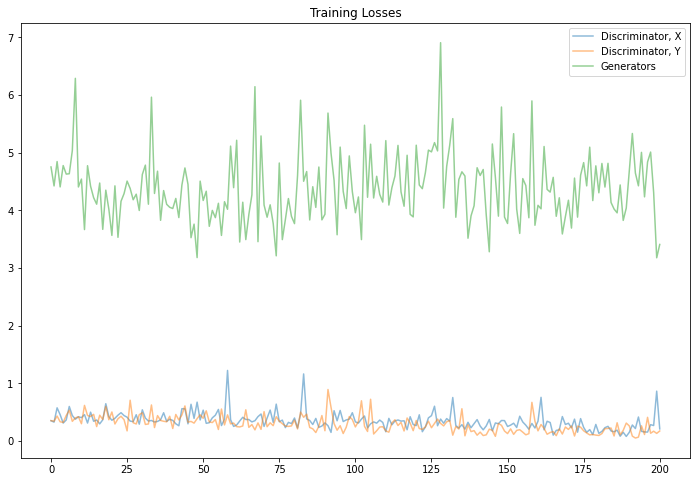

In [78]:
n_epochs = 2000
losses = training_loop(dataloader_X, dataloader_Y, test_dataloader_X, test_dataloader_Y, n_epochs=n_epochs)

fig, ax = plt.subplots(figsize=(12,8))
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator, X', alpha=0.5)
plt.plot(losses.T[1], label='Discriminator, Y', alpha=0.5)
plt.plot(losses.T[2], label='Generators', alpha=0.5)
plt.title("Training Losses")
plt.legend()

In [79]:
import matplotlib.image as mpimg

# helper visualization code
def view_samples(iteration, sample_dir='samples_cyclegan'):
    
    # samples are named by iteration
    path_XtoY = os.path.join(sample_dir, 'sample-{:06d}-X-Y.png'.format(iteration))
    path_YtoX = os.path.join(sample_dir, 'sample-{:06d}-Y-X.png'.format(iteration))
    
    # read in those samples
    try: 
        x2y = mpimg.imread(path_XtoY)
        y2x = mpimg.imread(path_YtoX)
    except:
        print('Invalid number of iterations.')
    
    fig, (ax1, ax2) = plt.subplots(figsize=(18,20), nrows=2, ncols=1, sharey=True, sharex=True)
    ax1.imshow(x2y)
    ax1.set_title('X to Y')
    ax2.imshow(y2x)
    ax2.set_title('Y to X')

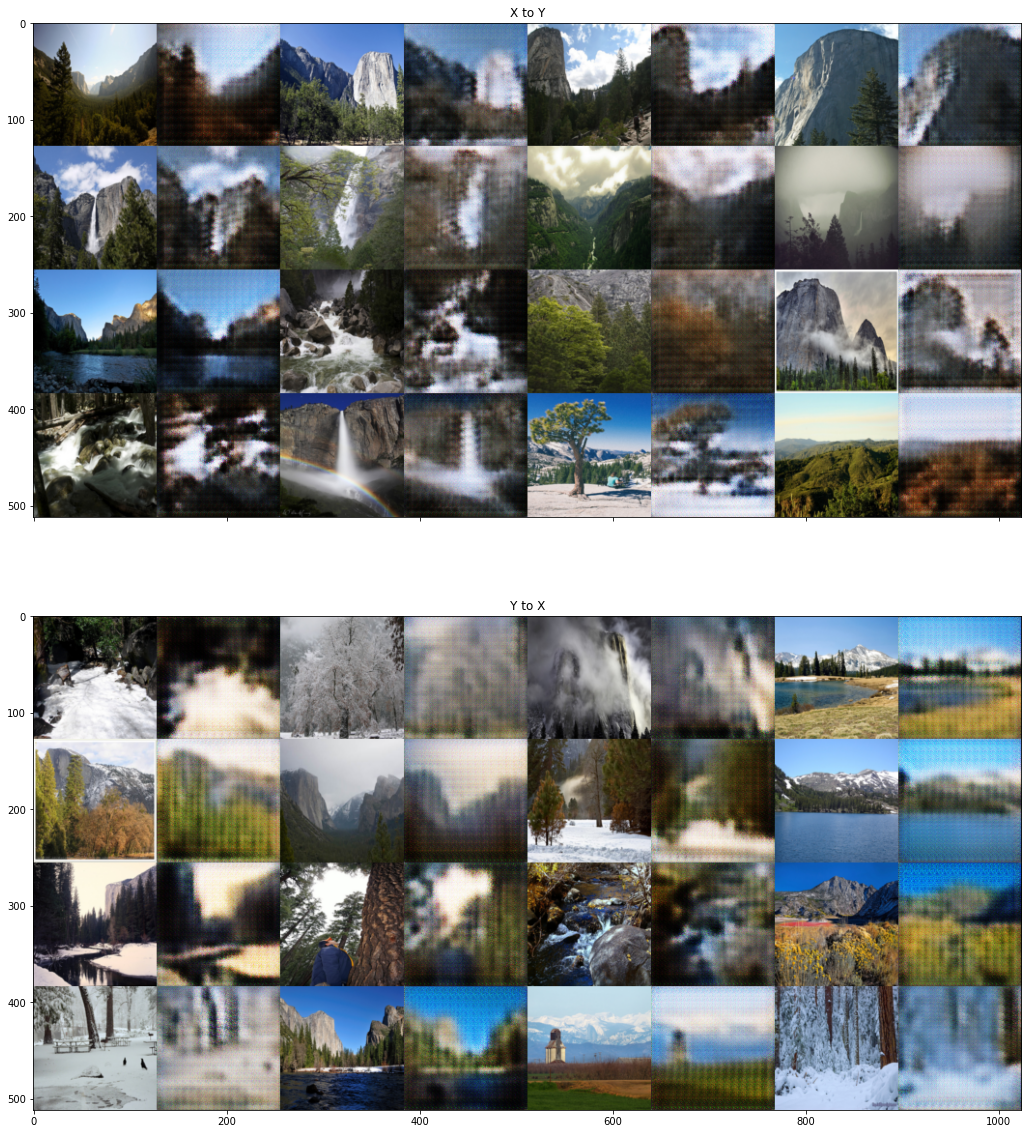

In [80]:
# view samples at iteration 100
view_samples(100, 'samples_cyclegan')

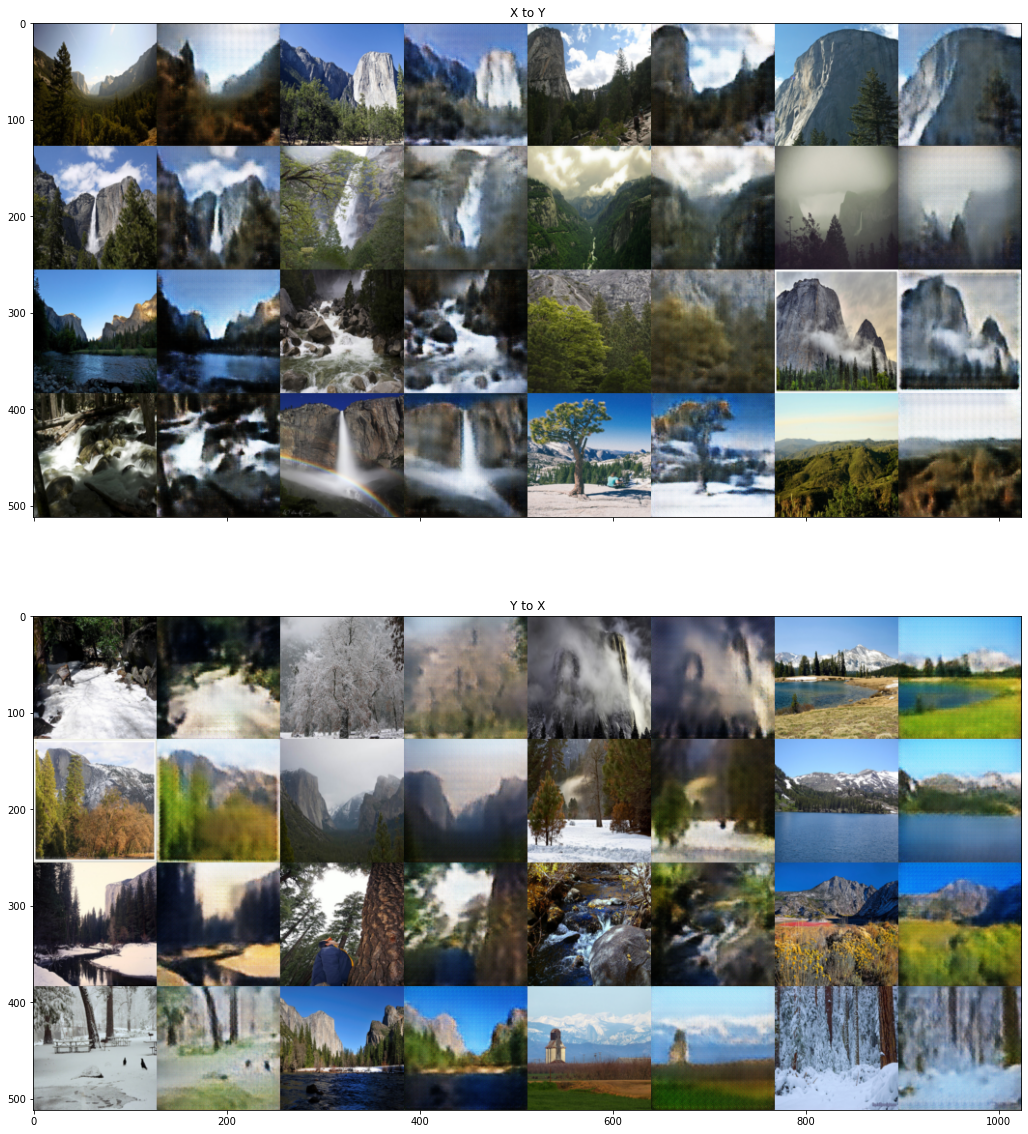

In [81]:
# view samples at iteration 2000
view_samples(2000, 'samples_cyclegan')